# 📝 Notebook-Dokumentation

**Notebook:** `13_.ipynb`  
**Beschreibung:**  
Liest OSM-Attraktionen aus Schritt 12 und ÖPNV-Haltestellen aus GTFS-Daten ein. Bringt beide auf ein einheitliches Format und kombiniert sie zu einer gemeinsamen Datei für weitere Verarbeitung.

---

### 📥 Input
- `/data/attractions/osm_processing/germany_attr_cleaned_scoring_25-04-09.parquet`  
  (bereinigte, kategorisierte OSM-Attraktionen aus Schritt 12)
  
- `/data/attractions/aggregated_stops_gtfs_germany_2025.gpkg`  
  (GTFS Haltestellen, kommen aus GTFS Deutschland und wurden mit QGIS-Erweiterung GTFS-Go extrahiert)

---

### 🔧 Verarbeitungsschritte

- Einlesen beider Datenquellen
- Harmonisierung der Struktur (Spaltennamen, Formate, Geometrien)
- Vereinheitlichung von Kategorien / Typen
- Scroring für die PT Stops basierend auf den täglischen Halten eines Stops
- Zusammenführung beider Datensätze zu einem gemeinsamen POI-Format

---

### 📤 Output

- `data/attractions/attr_germany_all_shapes_25-05-12.parquet`  
  (enthält OSM-Attraktionen und GTFS-Haltestellen im gemeinsamen Format und beides inkl. Scoring!)

---


In [3]:
import json
import pandas as pd
import geopandas as gpd

In [4]:
import requests
import contextily as ctx

import matplotlib.pyplot as plt
import altair as alt

import numpy

### read attractions (office, leisure, amenity, shop, landuse, healthcare)

In [5]:
attr_pois= gpd.read_parquet("data/attractions/osm_processing/germany_attr_cleaned_scoring_25-04-09.parquet")

<Axes: >

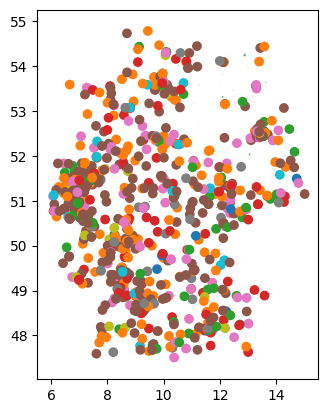

In [6]:
attr_pois[::1000].plot(column='custom_category')#, legend=True)

In [7]:
# sample without the landuse stuff
#attr_pois=attr_pois[attr_pois.osm_category!="landuse"].copy()

In [8]:
#attr_pois.plot(column='custom_category')#, legend=True)

In [9]:
attr_pois['attr']='attr_pois'
attr_pois=attr_pois.rename(columns={'custom_category':'cat','scoring':'score'})
attr_pois

### pt stops

In [17]:
## braucht man nur wenn man nur einzelne Bundesländer laden will
#url_bundeslaender = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json"
#bundeslaender  = gpd.read_file(url_bundeslaender)

In [18]:
gtfs_stops=gpd.read_file("data/attractions/aggregated_stops_gtfs_germany_2025.gpkg", 
                         #mask=bundeslaender
                        )

In [19]:
#gtfs_stops_gem=gtfs_stops.clip(shape_gem)

In [20]:
### export stops for review
#m = gtfs_stops[gtfs_stops['count']>0].explore(
#    name="gtfs_stops",
#    column="count",
#    tiles="CartoDB positron",
#    style_kwds={"style_function":lambda x: {"radius":(x["properties"]["count"]+40)/25}}
#)
#m.save("VRS_stops.html")

<Axes: >

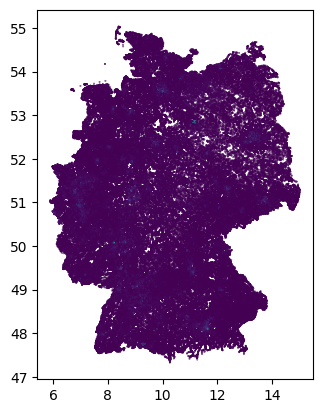

In [21]:
gtfs_stops.plot(column='count', markersize=0.1)

#### plotte die pt stops

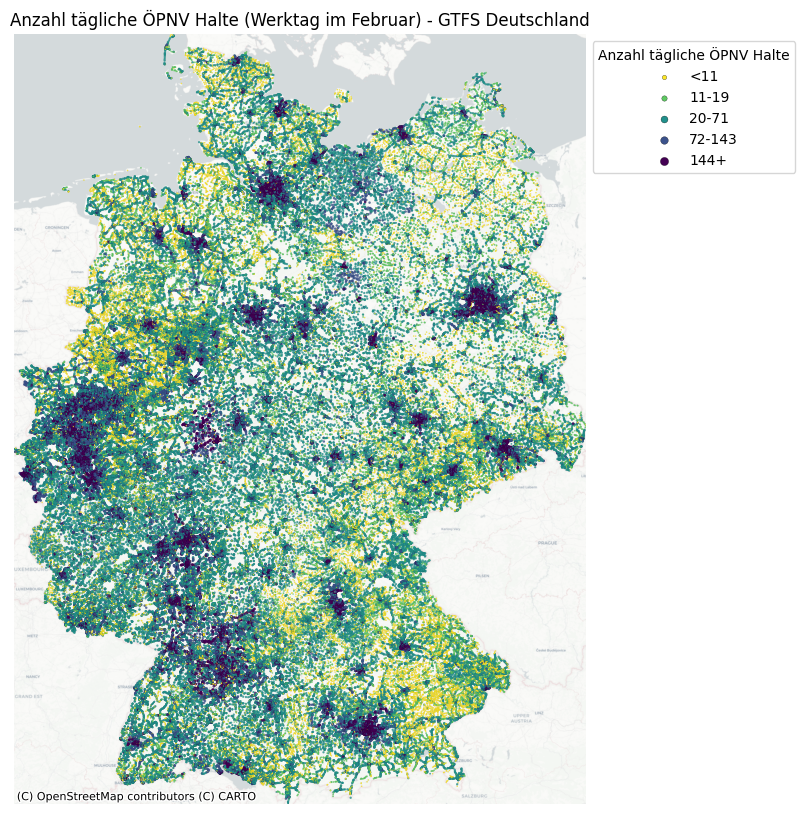

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import contextily as ctx  # Import contextily for basemaps

# Assuming gtfs_stops is your GeoDataFrame with a 'count' column

# Ensure the GeoDataFrame is in EPSG:3857 for compatibility with contextily
gtfs_stops_3857 = gtfs_stops.to_crs(epsg=3857).copy()

# Define bins and corresponding sizes
bins = [0, 11, 20, 72, 144, float('inf')]  # Upper bounds for bins
size_values = [0.02, 0.03, 0.05, 0.06, 0.07]  # Corresponding marker sizes
labels = ["<11", "11-19", "20-71", "72-143", "144+"]  # Correct bin labels

# Assign sizes using pandas cut
gtfs_stops_3857["size"] = pd.cut(gtfs_stops_3857["count"], bins=bins, labels=size_values, include_lowest=True).astype(float)

# Define alpha values based on count (smaller counts = higher transparency)
alpha_min, alpha_max = 0.2, 0.8  # Transparency range
gtfs_stops_3857["alpha"] = np.interp(gtfs_stops_3857["count"], (gtfs_stops_3857["count"].min(), gtfs_stops_3857["count"].max()), (alpha_max, alpha_min))

# Define a **custom colormap** with more contrast
colors = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154"]  # High-contrast viridis-like palette
custom_cmap = mcolors.ListedColormap(colors)  # Discrete colormap
norm = mcolors.BoundaryNorm(bins, custom_cmap.N)  # Ensure bin-mapped colors

# Assign colors based on bins
gtfs_stops_3857["color"] = [custom_cmap(norm(v)) for v in gtfs_stops_3857["count"]]

# Get bounding box for setting limits
min_x, min_y, max_x, max_y = gtfs_stops_3857.total_bounds

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot GTFS stops using `plot()` (CRS correctly aligned)
gtfs_stops_3857.plot(
    ax=ax, alpha=gtfs_stops_3857["alpha"], color=gtfs_stops_3857["color"], 
    markersize=gtfs_stops_3857["size"] * 50, edgecolor="black", linewidth=0.02
)

# Adjust axis limits before adding basemap
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Add basemap with correct CRS
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gtfs_stops_3857.crs.to_string(), zoom=8)

# Remove axis labels (for cleaner look)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Create a custom legend with **opaque colors** (no alpha)
handles = []
for label, size, bin_idx in zip(labels, size_values, range(len(colors))):
    legend_color = custom_cmap(bin_idx)  # Get color from colormap
    
    # Add legend markers (No alpha applied here)
    handles.append(plt.scatter([], [], s=size * 500, color=legend_color, alpha=1, label=label, edgecolors="black", linewidth=0.2))

# Place legend outside of the plot
ax.legend(handles=handles, title="Anzahl tägliche ÖPNV Halte", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
ax.set_title("Anzahl tägliche ÖPNV Halte (Werktag im Februar) - GTFS Deutschland", fontsize=12)

plt.show()


In [25]:
gtfs_stops=gtfs_stops.rename(columns={'similar_stop_name':'name'})
gtfs_stops['stops_count']=gtfs_stops['count']

gtfs_stops['cat']='OePNV Haltepunkt'
gtfs_stops['attr']='pt_stops'

#gtfs_stops_gem['score']=1. # add dummy

In [26]:
gtfs_stops.head()

,name,similar_stop_id,count,geometry,stops_count,cat,attr
0,Rech (Ahr) Rotweinstraße,de:07131:080340,51,POINT (7.03743 50.51487),51,OePNV Haltepunkt,pt_stops
1,Bad Neuenahr-Ahrweiler Ahrweiler BABZ,de:07131:080024:01:01,45,POINT (7.10796 50.52928),45,OePNV Haltepunkt,pt_stops
2,Sinzig Löhndorf Ehrenmal,de:07131:080132:01:01,59,POINT (7.19737 50.53015),59,OePNV Haltepunkt,pt_stops
3,Sinzig Löhndorf Nordstraße,de:07131:080133:02:02,55,POINT (7.20223 50.53066),55,OePNV Haltepunkt,pt_stops
4,Bad Neuenahr-Ahrweiler Walporzheim Sanct Peter,de:07131:080075:01:01,47,POINT (7.07737 50.53073),47,OePNV Haltepunkt,pt_stops


### adding scoring for PT-Stops

In [27]:

# add scoring based on values
def addScore(attr):
    if attr<11:
        return 1
    if attr>=11 and attr<20:
        return 1.5
    if attr>=20 and attr<72:
        return 2
    if attr>=72 and attr<144:
        return 2.5
    if attr>=144:
        return 3


gtfs_stops['score']=gtfs_stops.apply(lambda x: addScore(x["count"]), axis=1)

In [28]:
gtfs_stops.head()

,name,similar_stop_id,count,geometry,stops_count,cat,attr,score
0,Rech (Ahr) Rotweinstraße,de:07131:080340,51,POINT (7.03743 50.51487),51,OePNV Haltepunkt,pt_stops,2.0
1,Bad Neuenahr-Ahrweiler Ahrweiler BABZ,de:07131:080024:01:01,45,POINT (7.10796 50.52928),45,OePNV Haltepunkt,pt_stops,2.0
2,Sinzig Löhndorf Ehrenmal,de:07131:080132:01:01,59,POINT (7.19737 50.53015),59,OePNV Haltepunkt,pt_stops,2.0
3,Sinzig Löhndorf Nordstraße,de:07131:080133:02:02,55,POINT (7.20223 50.53066),55,OePNV Haltepunkt,pt_stops,2.0
4,Bad Neuenahr-Ahrweiler Walporzheim Sanct Peter,de:07131:080075:01:01,47,POINT (7.07737 50.53073),47,OePNV Haltepunkt,pt_stops,2.0


In [29]:
attr_all=pd.concat([attr_pois[['name','cat','attr','score','geometry','osm_category', 'poi_type']],gtfs_stops[['name','cat','attr','score','geometry', 'stops_count']]]).reset_index(drop=True)

In [30]:
attr_all

,name,cat,attr,score,geometry,osm_category,poi_type,stops_count
0,Papa-Pizza,Freizeit und Kultur,attr_pois,0.5,POINT (6.94125 50.91559),amenity,fast_food,NaN
1,Hartis Cafe,Freizeit und Kultur,attr_pois,0.5,POINT (6.96393 50.9052),amenity,restaurant,NaN
2,Grundmühle,Freizeit und Kultur,attr_pois,0.5,POINT (13.65719 51.11308),amenity,restaurant,NaN
3,Shell,Versorgung (Lebensmittel),attr_pois,2.5,POINT (13.64555 51.01484),amenity,fuel,NaN
4,Aral,Versorgung (Lebensmittel),attr_pois,2.5,POINT (8.3896 48.99517),amenity,fuel,NaN
...,...,...,...,...,...,...,...,...
4919701,"Klieken, Schule",OePNV Haltepunkt,pt_stops,1.5,POINT (12.3765 51.89085),NaN,NaN,14.0
4919702,Coswig(Anh),OePNV Haltepunkt,pt_stops,2.0,POINT (12.45762 51.888),NaN,NaN,46.0
4919703,Griebo,OePNV Haltepunkt,pt_stops,2.0,POINT (12.52298 51.88058),NaN,NaN,39.0
4919704,Klieken,OePNV Haltepunkt,pt_stops,2.0,POINT (12.37178 51.89453),NaN,NaN,39.0


In [31]:
attr_all = attr_all.reset_index().rename(columns={'index': 'poi_index'})

In [32]:
# prepare for new score cat limits, by adding value to poi_type
attr_all.loc[attr_all["cat"] == "OePNV Haltepunkt", "poi_type"] = "pt_stop"

-----

In [33]:
#fig, ax = plt.subplots(1, figsize=(10, 10))
#
##pop_gem_plt=pop_raster_poly.to_crs(epsg=3857)
#shape_plt=shape_gem.to_crs(epsg=3857)
##pop_raster_cent_plt=pop_raster_cent.to_crs(epsg=3857)
#attr_all_plt=attr_all.to_crs(epsg=3857)
#
#shape_plt.plot(ax=ax, alpha=0.3, linewidth=1.6, edgecolor='black', color='gray')
##pop_gem_plt.plot(ax=ax, column="Einwohner",alpha=0.3, linewidth=1.6, edgecolor='white', scheme='quantiles', k = 4)
#attr_all_plt[::100].plot(ax=ax, alpha=0.9, column='cat', markersize=5,edgecolor='white', linewidth=0.6, legend=True, legend_kwds={'loc':'center left', 'bbox_to_anchor':(1, 0.5)}) #, 'bbox_to_anchor':'(0.5, 0.5)'
#
#
#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
#ax.axis('off')

In [34]:
# prepare for new score cat limits, by adding value to poi_type
attr_all.loc[attr_all["cat"] == "OePNV Haltepunkt", "poi_type"] = "pt_stop"

In [35]:
attr_all

,poi_index,name,cat,attr,score,geometry,osm_category,poi_type,stops_count
0,0,Papa-Pizza,Freizeit und Kultur,attr_pois,0.5,POINT (6.94125 50.91559),amenity,fast_food,NaN
1,1,Hartis Cafe,Freizeit und Kultur,attr_pois,0.5,POINT (6.96393 50.9052),amenity,restaurant,NaN
2,2,Grundmühle,Freizeit und Kultur,attr_pois,0.5,POINT (13.65719 51.11308),amenity,restaurant,NaN
3,3,Shell,Versorgung (Lebensmittel),attr_pois,2.5,POINT (13.64555 51.01484),amenity,fuel,NaN
4,4,Aral,Versorgung (Lebensmittel),attr_pois,2.5,POINT (8.3896 48.99517),amenity,fuel,NaN
...,...,...,...,...,...,...,...,...,...
4919701,4919701,"Klieken, Schule",OePNV Haltepunkt,pt_stops,1.5,POINT (12.3765 51.89085),NaN,pt_stop,14.0
4919702,4919702,Coswig(Anh),OePNV Haltepunkt,pt_stops,2.0,POINT (12.45762 51.888),NaN,pt_stop,46.0
4919703,4919703,Griebo,OePNV Haltepunkt,pt_stops,2.0,POINT (12.52298 51.88058),NaN,pt_stop,39.0
4919704,4919704,Klieken,OePNV Haltepunkt,pt_stops,2.0,POINT (12.37178 51.89453),NaN,pt_stop,39.0


In [36]:
#attr_all.to_parquet("data/rbz_koeln/attr_NRW_all_shapes_25-03-20.parquet")
attr_all.to_parquet("data/attractions/attr_germany_all_shapes_25-05-12.parquet")